Data Preprocessing

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5784\1871112937.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Predicted Adj Close'] = lr_model.predict(train_data[features])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5784\1871112937.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Adj Close'] = lr_model.predict(test_data[features])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5784\1871112937.py:34: SettingWithCopyWarning: 
A value is trying to b

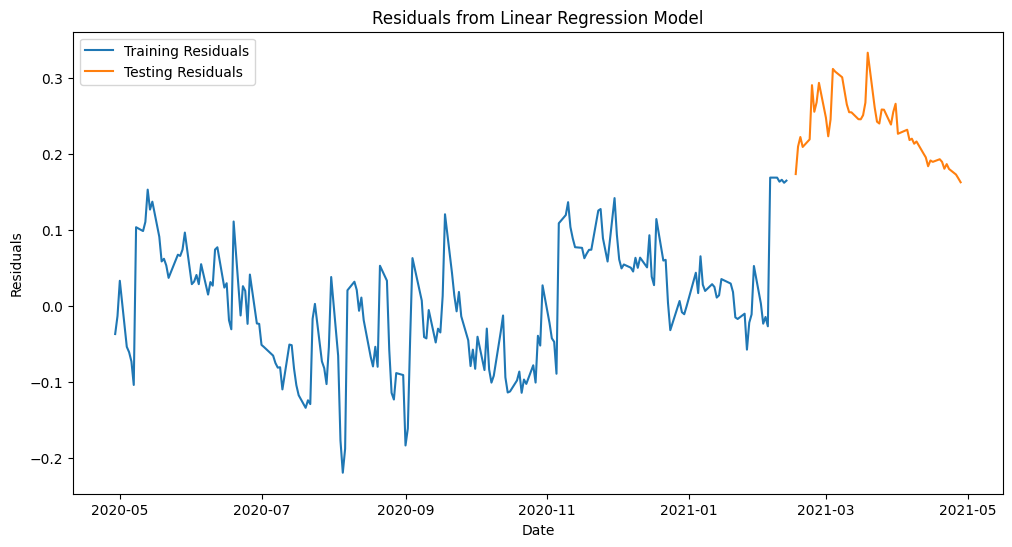

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Load the data
file_path = 'AAPL.csv' # Change to your file path
aapl_data = pd.read_csv(file_path)

# Convert dates to datetime format
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])

# Calculate daily returns
aapl_data['Daily Return'] = aapl_data['Adj Close'].pct_change()

# Drop NaN values
aapl_data = aapl_data.dropna()

# Split the dataset into training and testing sets
train_size = int(len(aapl_data) * 0.8)
train_data = aapl_data.iloc[:train_size]
test_data = aapl_data.iloc[train_size:]

# Baseline Model - Linear Regression
features = ['Open', 'High', 'Low', 'Close', 'Volume']
lr_model = LinearRegression()
lr_model.fit(train_data[features], train_data['Adj Close'])

# Predict and calculate residuals
train_data['Predicted Adj Close'] = lr_model.predict(train_data[features])
test_data['Predicted Adj Close'] = lr_model.predict(test_data[features])
train_data['Residual'] = train_data['Adj Close'] - train_data['Predicted Adj Close']
test_data['Residual'] = test_data['Adj Close'] - test_data['Predicted Adj Close']

# Plotting residuals
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Residual'], label='Training Residuals')
plt.plot(test_data['Date'], test_data['Residual'], label='Testing Residuals')
plt.title('Residuals from Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Preparing Data for RNN Models

In [7]:
# Sequence length
sequence_length = 10

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Extract and normalize residuals
scaler = MinMaxScaler(feature_range=(0, 1))
train_residuals = scaler.fit_transform(train_data['Residual'].values.reshape(-1, 1))
test_residuals = scaler.transform(test_data['Residual'].values.reshape(-1, 1))

# Create sequences for RNN input
X_train, y_train = create_sequences(train_residuals, sequence_length)
X_test, y_test = create_sequences(test_residuals, sequence_length)


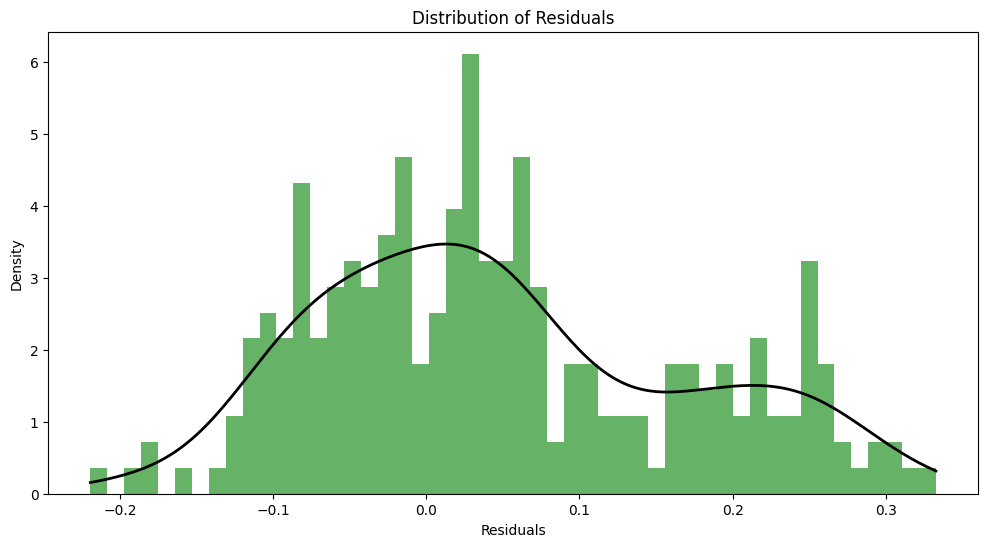

In [8]:
# Assuming train_data['Residual'] and test_data['Residual'] are available from the previous steps

# Combine train and test residuals
all_residuals = np.concatenate([train_data['Residual'], test_data['Residual']])

# Plotting the distribution of residuals
plt.figure(figsize=(12, 6))
plt.hist(all_residuals, bins=50, density=True, alpha=0.6, color='g')

# Plotting KDE (Kernel Density Estimate)
from scipy.stats import gaussian_kde
density = gaussian_kde(all_residuals)
xs = np.linspace(min(all_residuals), max(all_residuals), 200)
plt.plot(xs, density(xs), 'k', linewidth=2)

plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

RNN Model Implementation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_dim = X_train.shape[2]  # Number of features
hidden_dim = 50
output_dim = 1

# Instantiate the model
model = RNNModel(input_dim, hidden_dim, output_dim)

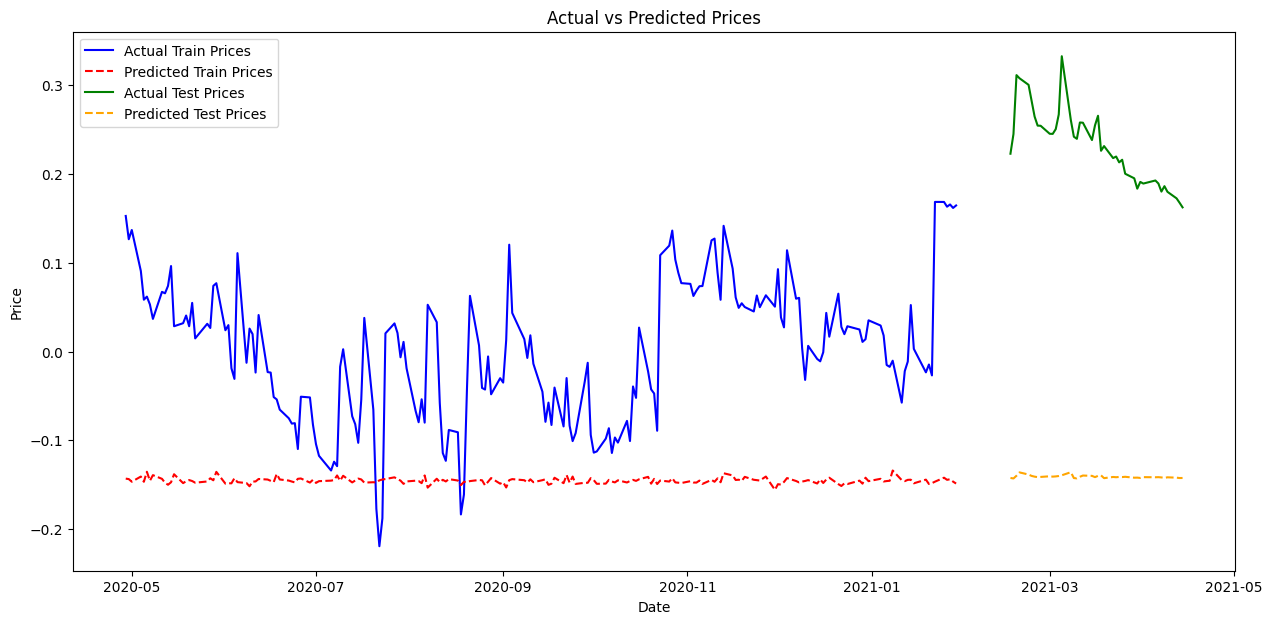

In [10]:
# Assuming `model` is already trained and `scaler` is the MinMaxScaler instance used earlier

# Function to reverse the scaling of the data
def inverse_transform(scaler, data, column_index):
    dummy = np.zeros(shape=(len(data), scaler.n_features_in_))
    dummy[:, column_index] = data[:, 0]
    return scaler.inverse_transform(dummy)[:, column_index]

# Get predictions
model.eval()
train_preds = []
test_preds = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_preds.extend(outputs.numpy())
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_preds.extend(outputs.numpy())

# Inverse transform the predictions and the true values
train_preds = inverse_transform(scaler, np.array(train_preds), 0)
y_train_inverse = inverse_transform(scaler, y_train, 0)
test_preds = inverse_transform(scaler, np.array(test_preds), 0)
y_test_inverse = inverse_transform(scaler, y_test, 0)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(train_data['Date'][:len(y_train_inverse)], y_train_inverse, color='blue', label='Actual Train Prices')
plt.plot(train_data['Date'][:len(train_preds)], train_preds, color='red', linestyle='--', label='Predicted Train Prices')
plt.plot(test_data['Date'][:len(y_test_inverse)], y_test_inverse, color='green', label='Actual Test Prices')
plt.plot(test_data['Date'][:len(test_preds)], test_preds, color='orange', linestyle='--', label='Predicted Test Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Train the Model

Epoch [1/50], Train Loss: 0.1116, Test Loss: 0.3293
Epoch [2/50], Train Loss: 0.0441, Test Loss: 0.1493
Epoch [3/50], Train Loss: 0.0402, Test Loss: 0.2538
Epoch [4/50], Train Loss: 0.0343, Test Loss: 0.2855
Epoch [5/50], Train Loss: 0.0341, Test Loss: 0.2327
Epoch [6/50], Train Loss: 0.0309, Test Loss: 0.1632
Epoch [7/50], Train Loss: 0.0306, Test Loss: 0.1639
Epoch [8/50], Train Loss: 0.0288, Test Loss: 0.1921
Epoch [9/50], Train Loss: 0.0274, Test Loss: 0.1484
Epoch [10/50], Train Loss: 0.0257, Test Loss: 0.1100
Epoch [11/50], Train Loss: 0.0244, Test Loss: 0.1039
Epoch [12/50], Train Loss: 0.0225, Test Loss: 0.0801
Epoch [13/50], Train Loss: 0.0211, Test Loss: 0.0370
Epoch [14/50], Train Loss: 0.0199, Test Loss: 0.0267
Epoch [15/50], Train Loss: 0.0192, Test Loss: 0.0088
Epoch [16/50], Train Loss: 0.0205, Test Loss: 0.0061
Epoch [17/50], Train Loss: 0.0216, Test Loss: 0.0345
Epoch [18/50], Train Loss: 0.0195, Test Loss: 0.0242
Epoch [19/50], Train Loss: 0.0191, Test Loss: 0.0286
Ep

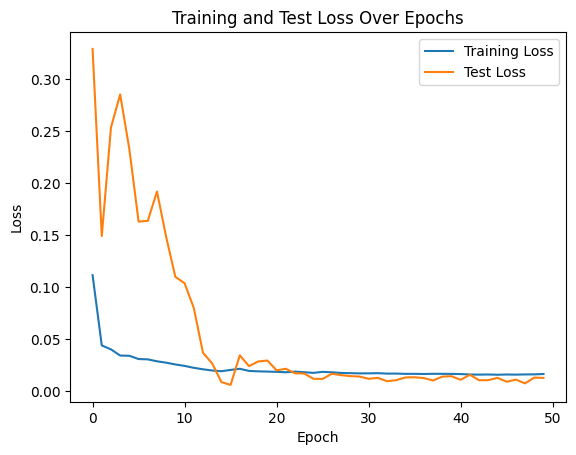

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss values
train_losses = []
test_losses = []

# Training loop with loss tracking
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test data
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Plot the training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
